## Desafío - Inferencia de tópicos con EM
- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
        - El desafío se debe desarrollar de manera Individual.
        - Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío Inferencia de tópicos con EM.

### Requerimientos
- En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se    encuentra en la carpeta dump.
- Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
- En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción.
- Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

### Ejercicio 1: Preparar el ambiente de trabajo
- Importe los módulos numpy, pandas, matplotlib, seaborn, glob y os siguiendo las
  buenas prácticas. Los últimos dos módulos permitirán realizar la importación de
  múltiples archivos dentro de la carpeta dump.
- Para ello genere un objeto que guarde en una lista todos los archivos alojados en
  dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas.
  Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.
- Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.


In [1]:
# Triada calsica.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Graficos seaborn, warnings y datos perdidos.
import seaborn as sns
import warnings
import missingno as msngo

# Importaciones especificas de este desafio.
import glob, os

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Otras librerias, configuraciones e instancias.
labelencoder = LabelEncoder()
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('seaborn-darkgrid')

In [2]:
csv_list = glob.glob('Datasets/dump/*.csv')
name_csv = []

In [3]:
for i in csv_list:
        name_csv.append(pd.read_csv(i, index_col = None, header = 0).drop(columns = 'Unnamed: 0'))

df_letras = pd.concat(name_csv)
df_letras.columns = ['Artista', 'Genero', 'Cancion', 'Letra']

In [4]:
df_letras.head()

,Artista,Genero,Cancion,Letra
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...


### Ejercicio 2: Matriz de ocurrencias
- Importe la clase CountVectorizer dentro de los módulos
  feature_extraction.text de la librería sklearn.
- Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de
  datos.
- Con la clase inicializada, incorpore las letras con el método fit_transform y guarde
  los resultados en un nuevo objeto.

In [5]:
# instanciamos un objeto CountVectorizer()
count_vectorizer = CountVectorizer(stop_words = 'english')

In [6]:
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(df_letras.Letra)

In [7]:
# Extraemos tokens (palabras)
words  = count_vectorizer.get_feature_names()
words[:10]

['00', '000', '007', '01', '019', '02', '0281', '03', '04', '05']

In [8]:
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis = 0)
words_freq[:10]

array([14, 42,  2, 13,  3,  3,  1,  4,  3,  5], dtype=int64)

In [9]:
# creamos un nuevo dataframe
words_freq_df = pd.DataFrame([list(words), list(words_freq)]).T
words_freq_df.head()

,0,1
0,00,14
1,000,42
2,007,2
3,01,13
4,019,3


In [10]:
words_freq_df.columns= ['word', 'freq']
words_freq_df = words_freq_df.sort_values(by='freq', ascending = False).iloc[0:5000, :]
words_freq_df.head()

,word,freq
24950,like,19629
12859,don,17398
23856,know,14962
18439,got,14171
23287,just,13978


### Ejercicio 3: Entrenamiento del Modelo
- Importe sklearn.decomposition.LatentDirichletAllocation y
  sklearn.model_selection.GridSearchCV.
- Genere una búsqueda de grilla con los siguientes hiper parámetros:
        - n_components: [5, 10, 15].
        - learning_decay: [0.7, 0.5].
- Entrene la búsqueda de grilla con las letras en un formato vectorizado con
  CountVectorizer.
- Reporte brevemente cuál es la mejor combinación de hiper parámetros.

#### Digresión: Latent Dirichlet Allocation
Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia
Variacional EM. La principal utilidad de esto es la identificación de tópicos en un corpus de
texto. El proceso de inferencia se puede resumir en los siguientes pasos:

- Cada documento dentro del corpus se puede entender como una mezcla de tópicos
  comunes a nivel de corpus.
- Esta mezcla de tópicos es latente: sólo observamos los documentos registrados y
  sus palabras.
La API de sklearn.decomposition.LatentDirichletAllocation presenta la
misma funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la
inicialización de la clase son:

  - n_components: Cantidad de tópicos a inferir en un corpus.
  - learning_method: Forma en la que entran los datos en entrenamiento.
    Cuando es 'batch', se ingresa la matriz de entrenamiento completa. Cuando
    es 'online', la matriz de entrenamiento ingresa de manera secuencial en
    parcelas pequeñas.
  - learning_decay: Tasa de aprendizaje en la función de pérdida. Cuando se
    implementa con learning_method='online', el modelo se entrena con
    Gradiente Estocástico Descendente.
  - Perplejidad: Busca aproximar el número óptimo de tópicos a inferir.
    Técnicamente evalúa qué tan bien predice una muestra específica. En función
    a un número de tópicos, define la distribución teórica de palabras
    representada por los tópicos y la compara con la ocurrencia empírica de
    palabras en tópicos.


In [11]:
param_grid = {'n_components': [5, 10, 15], 'learning_decay': [0.7, 0.5]}

In [12]:
lda = LatentDirichletAllocation(learning_method = 'online')

In [13]:
# n_jobs = -1 significa usar todos los procesadores disponiobles
# verbose = 3 significa que los índices de parámetros de 
# pliegue y candidato también se muestran junto con la hora de inicio del cálculo.
# cv significa las validaciones cruzadas a realizar
model_gridcv = GridSearchCV(lda, param_grid, cv = 5, n_jobs = -1, verbose = 3)

In [14]:
model_gridcv.fit(count_vectorizer_fit)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=LatentDirichletAllocation(learning_method='online'),
             n_jobs=-1,
             param_grid={'learning_decay': [0.7, 0.5],
                         'n_components': [5, 10, 15]},
             verbose=3)

In [15]:
print(f'''
Mejores hiper parametros: {model_gridcv.best_params_}
Mejor Puntaje: {model_gridcv.best_score_}''')


Mejores hiper parametros: {'learning_decay': 0.5, 'n_components': 5}
Mejor Puntaje: -2555345.5907315593


### Ejercicio 4 : Inferencia e Identificación de Tópicos
- En base a la mejor combinación de hiper parámetros, entrene el modelo con la matriz
  de atributos de las letras.
- Para identificar de qué se trata cada tópico, necesitamos identificar las principales
  15 palabras asociadas con éste. Puede implementar la siguiente línea de código para
  identificar las principales palabras en un tópico:

In [16]:
count_vectorizer_i = CountVectorizer(stop_words = 'english')

In [17]:

count = count_vectorizer_i.fit_transform(df_letras.Letra)

In [18]:
# n_jobs = -1 significa usar todos los procesadores disponibles
# verbose = 3 significa que los índices de parámetros de 
# pliegue y candidato también se muestran junto con la hora de inicio del cálculo.
# cv significa las validaciones cruzadas a realizar
model_gridcv_i = GridSearchCV(lda, {'n_components': [5], 'learning_decay': [0.5]}, cv = 5, n_jobs = -1, verbose = 3)

In [19]:
model_gridcv_i.fit(count)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=LatentDirichletAllocation(learning_method='online'),
             n_jobs=-1,
             param_grid={'learning_decay': [0.5], 'n_components': [5]},
             verbose=3)

In [20]:
print(f'''
Mejores hiper parametros: {model_gridcv_i.best_params_}
Mejor Puntaje: {model_gridcv_i.best_score_}''')


Mejores hiper parametros: {'learning_decay': 0.5, 'n_components': 5}
Mejor Puntaje: -2554322.3985871635


In [21]:
best_estimator = model_gridcv_i.best_estimator_
best_estimator 

LatentDirichletAllocation(learning_decay=0.5, learning_method='online',
                          n_components=5)

In [22]:

# mediante .components_ podemos extraer una matriz que entrega las
# distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(best_estimator.components_):
        # para cada tópico
        print("tópico: {}".format(topic_id + 1))
        # mediante argsort logramos ordenar los elementos por magnitud
        # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
        # en la matriz dispersa y devolvemos el nombre.
        # finalmente concatenamos las palabras
        print(" ".join([count_vectorizer.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
ah future da song moment page lyrics able random display hopefully licensed unfortunately doo ba
tópico: 2
don love know oh yeah just got ll want let say like baby come ve
tópico: 3
like got shit yo nigga ain fuck man em niggas don cause ya know bitch
tópico: 4
life god world la die death soul eyes blood dead time pain ve mind war
tópico: 5
like night man home day sun ll just old light days time away run said


In [23]:
# Vista de clases
df_letras['Genero'].unique()

array(['metal', 'hiphop', 'rock', 'pop'], dtype=object)

- Comente a qué tópicos está asociada cada clase inferida.

### Ejercicio 5: Identificación de probabilidades
- En base a la información generada, es posible identificar cuales van a ser los géneros
  más probables de ocurrir para un artista.
- Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de
  datos original. Podemos implementar esto de la siguiente manera:

In [24]:
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_estimator.transform(count_vectorizer_fit)
# esta transformación la podemos coaccionar a un dataframe de la siguiente manera
# pasamos esta matriz y la redondeamos en 3 decimales
# agregamos un índice
topics_for_each_doc = pd.DataFrame(np.round(fit_best_lda, 3), index = df_letras.index)
# agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_estimator.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df_letras, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [25]:
# DataFrame con la probabilidad de los topicos para cada clase
concatenated_df.head()

,Artista,Genero,Cancion,Letra,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee...",0.004,0.056,0.057,0.556,0.328,4
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...,0.004,0.198,0.004,0.004,0.790,5
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...,0.049,0.480,0.002,0.002,0.468,2
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...,0.003,0.483,0.058,0.275,0.182,2
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...,0.003,0.003,0.036,0.539,0.420,4


In [26]:
concatenated_df.sample(50)

,Artista,Genero,Cancion,Letra,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
136,The Clash,rock,First Night Back In London,The mini cab \n The driver is black \n This ti...,0.004,0.067,0.274,0.004,0.651,5
295,Bruce Springsteen,rock,Outside Looking In,"It's all over now, the thing we had \n I ain't...",0.002,0.671,0.002,0.065,0.259,2
126,The Beatles,rock,While My Guitar Gently Weeps,I look at you all \n See the love there that's...,0.003,0.487,0.003,0.290,0.217,2
434,Bruce Springsteen,rock,Arabian Nights,Shrieks of Sheiks as they run across the movie...,0.008,0.270,0.134,0.120,0.467,5
215,The Smashing Pumpkins,rock,Inkless,The stars are out tonight \n And what you need...,0.003,0.499,0.003,0.262,0.233,2
57,Megadeth,metal,Millennium Of The Blind,At the start of time \n Many centuries ago \n ...,0.009,0.009,0.009,0.783,0.190,4
184,Britney Spears,pop,Right Now (Taste The Victory),Are you ready for me? \n Yeah! I Thought So \n...,0.002,0.849,0.002,0.145,0.002,2
145,Cannibal Corpse,metal,Rabid,Like a virus of the mind \n My rage will sprea...,0.140,0.002,0.023,0.755,0.080,4
51,Tool,metal,Rosetta Stoned,"All righty, then... picture this if you will \...",0.028,0.533,0.204,0.130,0.104,2
42,Eminem,hiphop,Stan,My tea's gone cold I'm wondering why I \n Got ...,0.000,0.493,0.299,0.017,0.191,2


In [27]:
concatenated_df.tail()

,Artista,Genero,Cancion,Letra,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
246,Weezer,rock,"Thief, You've Taken All That Was Me","Thief, of silent dreams \n Of golden scenes \n...",0.003,0.003,0.003,0.644,0.348,4
247,Weezer,rock,We Are All In Love,When your out with your friends \n In your new...,0.013,0.960,0.003,0.002,0.022,2
248,Weezer,rock,We Go Together,We go together \n And that's to stay \n And in...,0.127,0.858,0.005,0.005,0.005,2
249,Weezer,rock,What Is This I Find?,[Jonas]: \n What is this I find? \n [Wuan]: \n...,0.371,0.364,0.061,0.006,0.198,1
250,Weezer,rock,Zep Jamb,Alright \n Say baby \n Love me \n Lay your mon...,0.005,0.978,0.005,0.005,0.005,2


In [28]:
df_result_topic = concatenated_df[['Genero', 'T: 1', 'T: 2', 'T: 3', 'T: 4', 'T: 5']].groupby('Genero').mean().reset_index()
df_result_topic

,Genero,T: 1,T: 2,T: 3,T: 4,T: 5
0,hiphop,0.025589,0.239762,0.525945,0.075795,0.132963
1,metal,0.048625,0.165886,0.043073,0.577276,0.165114
2,pop,0.044116,0.590048,0.147575,0.093868,0.124379
3,rock,0.082484,0.426415,0.059059,0.153506,0.278584


In [29]:
def selec_df_artist(df, artista):
        return df[df['Artista'] == artista].loc[:, 'T: 1':'T: 5']

In [42]:
# extraemos probabilidades de tópicos para la banda Weezer
mj_df = selec_df_artist(concatenated_df, 'Michael Jackson')
mj_df.shape

(279, 5)

<AxesSubplot:>

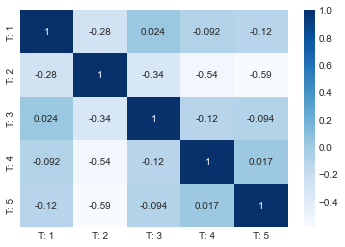

In [43]:
# Correlacion de topicos para la banda Weezer
sns.heatmap(mj_df.corr(), annot=True, cmap='Blues')

In [44]:
mj_df.mean()

T: 1    0.028810
T: 2    0.652892
T: 3    0.049161
T: 4    0.129244
T: 5    0.139821
dtype: float64

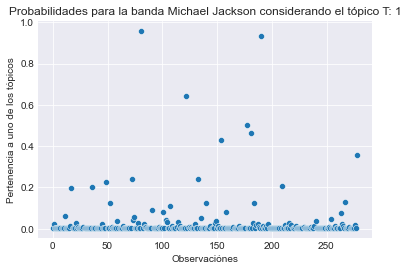

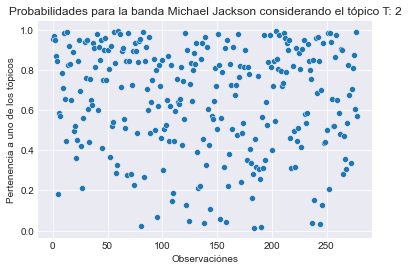

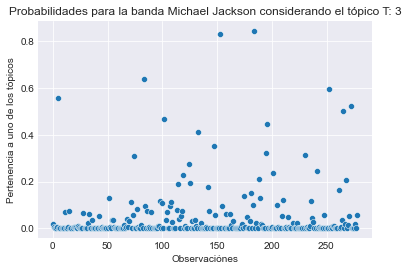

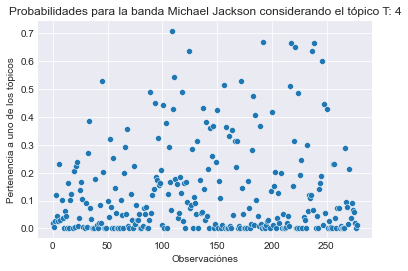

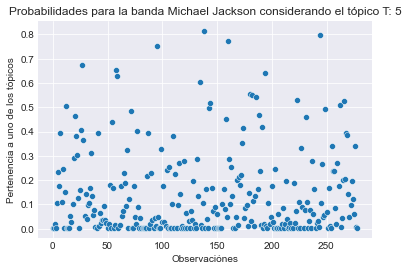

In [45]:
for col in mj_df.columns:
        sns.scatterplot(data = mj_df[col])
        plt.title(f'Probabilidades para la banda {"Michael Jackson"} considerando el tópico {col}')
        plt.ylabel('Pertenencia a uno de los tópicos')
        plt.xlabel('Observaciónes')
        plt.show()

Se puede observar que Michael Jackson tiene mayor porcentaje de pertenencia al topicos T: 2, con un 65% de pertenencia al topico

In [34]:
meshuggah_df = selec_df_artist(concatenated_df, 'Meshuggah')
meshuggah_df.shape

(81, 5)

<AxesSubplot:>

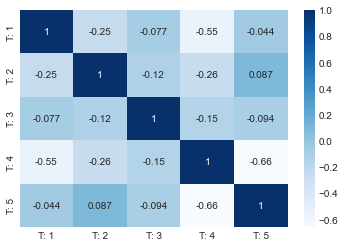

In [35]:
# Correlacion de topicos para la banda Meshuggah
sns.heatmap(meshuggah_df.corr(), annot=True, cmap='Blues')

In [36]:
meshuggah_df.mean()

T: 1    0.100617
T: 2    0.033753
T: 3    0.039519
T: 4    0.726481
T: 5    0.099593
dtype: float64

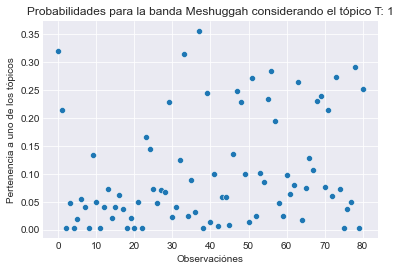

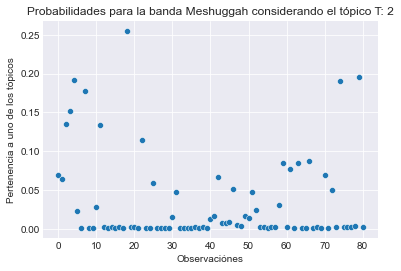

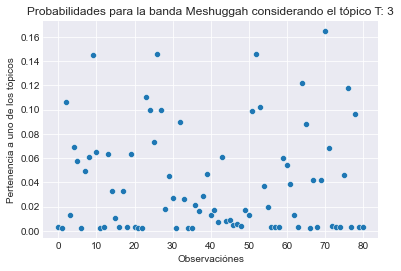

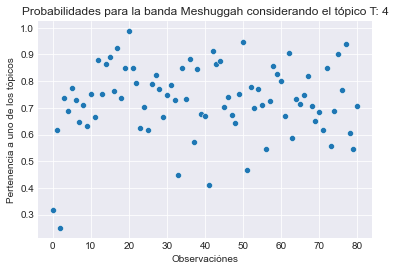

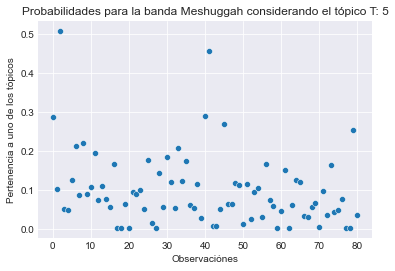

In [37]:
for col in meshuggah_df.columns:
        sns.scatterplot(data = meshuggah_df[col])
        plt.title(f'Probabilidades para la banda {"Meshuggah"} considerando el tópico {col}')
        plt.ylabel('Pertenencia a uno de los tópicos')
        plt.xlabel('Observaciónes')
        plt.show()

Se puede observar que la banda Meshuggah tiene mayor porcentaje de pertenencia al topico T: 4 y sin lugar a dudas corresponde al topico 4, lo que da un indicio de que el modelo es bueno prediciendo variables con pocos datos. En los graficos antes vistos podemos ver que si bien el modelo predice bien la ocurrencia para ambas bandas estudiadas, Meshuggah, que tiene mucho menos obsevaciones, presenta una clara tendencia al topico 5, al igual que Michael Jackson con un 65% de pertenencia al topico 2 con menos observaciones y los mismos hiper parametros.